In [1]:
from math import rsqrt  

@register_passable("trivial")
struct Vec3f:
    var data: SIMD[DType.float32, 4]

    @always_inline
    fn __init__(x: Float32, y: Float32, z: Float32) -> Self:
        return Vec3f{data: SIMD[DType.float32, 4](x, y, z, 0)}

    @always_inline
    fn __init__(data: SIMD[DType.float32, 4]) -> Self:
        return Vec3f {data: data}

    @always_inline
    @staticmethod
    fn zero() -> Vec3f:
        return Vec3f(0, 0, 0)

    @always_inline
    fn __sub__(self, other: Vec3f) -> Self:
        return self.data - other.data

    @always_inline
    fn __add__(self, other: Vec3f) -> Self:
        return self.data + other.data
    
    @always_inline
    fn __matmul__(self, other: Vec3f) -> Float32:
        return (self.data * other.data).reduce_add()

    @always_inline
    fn __mul__(self, k: Float32) -> Vec3f:
        return self.data * k

    @always_inline
    fn __neg__(self) -> Self:
        return self.data * -1.0

    @always_inline
    fn __getitem__(self, idx: Int) -> SIMD[DType.float32, 1]:
        return self.data[idx]

    @always_inline
    fn cross(self, other: Vec3f) -> Vec3f:
        let self_zxy = self.data.shuffle[2, 0, 1, 3]()
        let other_zxy = other.data.shuffle[2, 0, 1, 3]()
        return (self_zxy * other_zxy - self.data * other.data).shuffle[
            2, 0, 1, 3
        ]()

    @always_inline
    fn normalize(self) -> Vec3f:
        return self.data * rsqrt(self @ self)

In [2]:
%%python
from importlib.util import find_spec
import shutil
import subprocess

fix = """
-------------------------------------------------------------------------
fix following the steps here:
    https://github.com/modularml/mojo/issues/1085#issuecomment-1771403719
-------------------------------------------------------------------------
"""

def install_if_missing(name: str):
    if find_spec(name):
        return

    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path" + fix)
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found" + fix)

install_if_missing("numpy")
install_if_missing("matplotlib")

In [3]:
from python import Python
from python.object import PythonObject

struct Image:
    # reference count used to make the object efficient copyable
    var rc: Pointer[Int]
    # the two dimensional image is represented as a flat array
    var pixels: Pointer[Vec3f]
    var height: Int
    var width: Int

    fn __init__(inout self, height: Int, width: Int):
        self.height = height
        self.width = width
        self.pixels = Pointer[Vec3f].alloc(self.height * self.width)
        self.rc = Pointer[Int].alloc(1)
        self.rc.store(1)

    fn __copyinit__(inout self, other: Self):
        other._inc_rc()
        self.pixels = other.pixels
        self.rc = other.rc
        self.height = other.height
        self.width = other.width

    fn __del__(owned self):
        self._dec_rc()

    fn _get_rc(self) -> Int:
        return self.rc.load()

    fn _dec_rc(self):
        let rc = self._get_rc()
        if rc > 1:
            self.rc.store(rc - 1)
            return
        self._free()

    fn _inc_rc(self):
        let rc = self._get_rc()
        self.rc.store(rc + 1)

    fn _free(self):
        self.rc.free()
        self.pixels.free()

    @always_inline
    fn set(self, row: Int, col: Int, value: Vec3f) -> None:
        self.pixels.store(self._pos_to_index(row, col), value)

    @always_inline
    fn _pos_to_index(self, row: Int, col: Int) -> Int:
        # Convert a (row, col) position into an index in the underlying linear storage
        return row * self.width + col

    fn to_numpy_image(self) raises -> PythonObject:
        let np = Python.import_module("numpy")
        let plt = Python.import_module("matplotlib.pyplot")

        let np_image = np.zeros((self.height, self.width, 3), np.float32)

        # we use raw pointers to efficiently copy the pixels to the numpy array
        let out_pointer = Pointer(
            __mlir_op.`pop.index_to_pointer`[
                _type=__mlir_type[`!kgen.pointer<scalar<f32>>`]
            ](
                SIMD[DType.index, 1](
                    np_image.__array_interface__["data"][0].__index__()
                ).value
            )
        )
        let in_pointer = Pointer(
            __mlir_op.`pop.index_to_pointer`[
                _type=__mlir_type[`!kgen.pointer<scalar<f32>>`]
            ](SIMD[DType.index, 1](self.pixels.__as_index()).value)
        )

        for row in range(self.height):
            for col in range(self.width):
                let index = self._pos_to_index(row, col)
                for dim in range(3):
                    out_pointer.store(
                        index * 3 + dim, in_pointer[index * 4 + dim]
                    )
        return np_image

def load_image(fname: String) -> Image:
    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")

    let np_image = plt.imread(fname)
    let rows = np_image.shape[0].__index__()
    let cols = np_image.shape[1].__index__()
    let image = Image(rows, cols)

    let in_pointer = Pointer(
        __mlir_op.`pop.index_to_pointer`[
            _type=__mlir_type[`!kgen.pointer<scalar<f32>>`]
        ](
            SIMD[DType.index, 1](
                np_image.__array_interface__["data"][0].__index__()
            ).value
        )
    )
    let out_pointer = Pointer(
        __mlir_op.`pop.index_to_pointer`[
            _type=__mlir_type[`!kgen.pointer<scalar<f32>>`]
        ](SIMD[DType.index, 1](image.pixels.__as_index()).value)
    )
    for row in range(rows):
        for col in range(cols):
            let index = image._pos_to_index(row, col)
            for dim in range(3):
                out_pointer.store(
                    index * 4 + dim, in_pointer[index * 3 + dim]
                )
    return image

In [4]:
def render(image: Image):
    np = Python.import_module("numpy")
    plt = Python.import_module("matplotlib.pyplot")
    colors = Python.import_module("matplotlib.colors")
    dpi = 32
    fig = plt.figure(1, [image.height // 10, image.width //10], dpi)

    plt.imshow(image.to_numpy_image())
    plt.axis("off")
    plt.show()

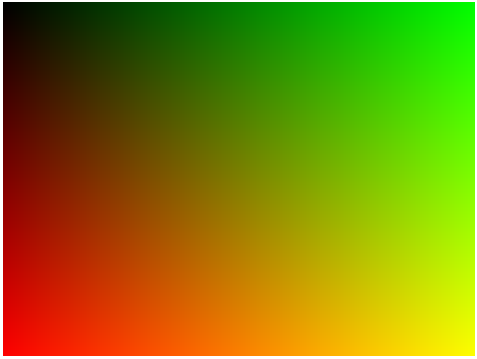

In [5]:
let image = Image(192, 256)

for row in range(image.height):
    for col in range(image.width):
        image.set(
            row,
            col,
            Vec3f(Float32(row) / image.height, Float32(col) / image.width, 0),
        )

render(image)

In [6]:
from math import sqrt

@register_passable("trivial")
struct Material:
    var color: Vec3f
    var albedo: Vec3f
    var specular_component: Float32

    fn __init__(color: Vec3f) -> Material:
        return Material {
            color: color, albedo: Vec3f(0, 0, 0), specular_component: 0
        }

    fn __init__(
        color: Vec3f, albedo: Vec3f, specular_component: Float32
    ) -> Material:
        return Material {
            color: color, albedo: albedo, specular_component: specular_component
        }


alias W = 1024
alias H = 768
alias bg_color = Vec3f(0.02, 0.02, 0.02)
let shiny_yellow = Material(Vec3f(0.95, 0.95, 0.4), Vec3f(0.7, 0.6, 0), 30.0)
let green_rubber = Material(Vec3f(0.3, 0.7, 0.3), Vec3f(0.9, 0.1, 0), 1.0)

@register_passable("trivial")
struct Sphere(CollectionElement):
    var center: Vec3f
    var radius: Float32
    var material: Material

    fn __init__(c: Vec3f, r: Float32, material: Material) -> Self:
        return Sphere {center: c, radius: r, material: material}

    @always_inline
    fn intersects(self, orig: Vec3f, dir: Vec3f, inout dist: Float32) -> Bool:
        """This method return True if a given ray intersects this sphere.
        And if it does, it writes in the `dist` parameter the distance to the 
        origin of the ray.
        """
        let L = orig - self.center
        let a = dir @ dir
        let b = 2 * (dir @ L)
        let c = L @ L - self.radius * self.radius
        let discriminant = b * b - 4 * a * c
        if discriminant < 0:
            return False
        if discriminant == 0:
            dist = -b / 2 *a
            return True
        let q = -0.5 * (b + sqrt(discriminant)) if b > 0 else -0.5 * (
            b - sqrt(discriminant)
        ) 
        var t0 = q / a
        let t1 = c / q
        if t0 > t1:
            t0 = t1
        if t0 < t1:
            t0 = t1
            if t0 < 0:
                return False

        dist = t0
        return True

In [7]:
fn cast_ray(orig: Vec3f, dir: Vec3f, sphere: Sphere) -> Vec3f:
    var dist: Float32 = 0
    if not sphere.intersects(orig, dir, dist):
        return bg_color
    
    return sphere.material.color


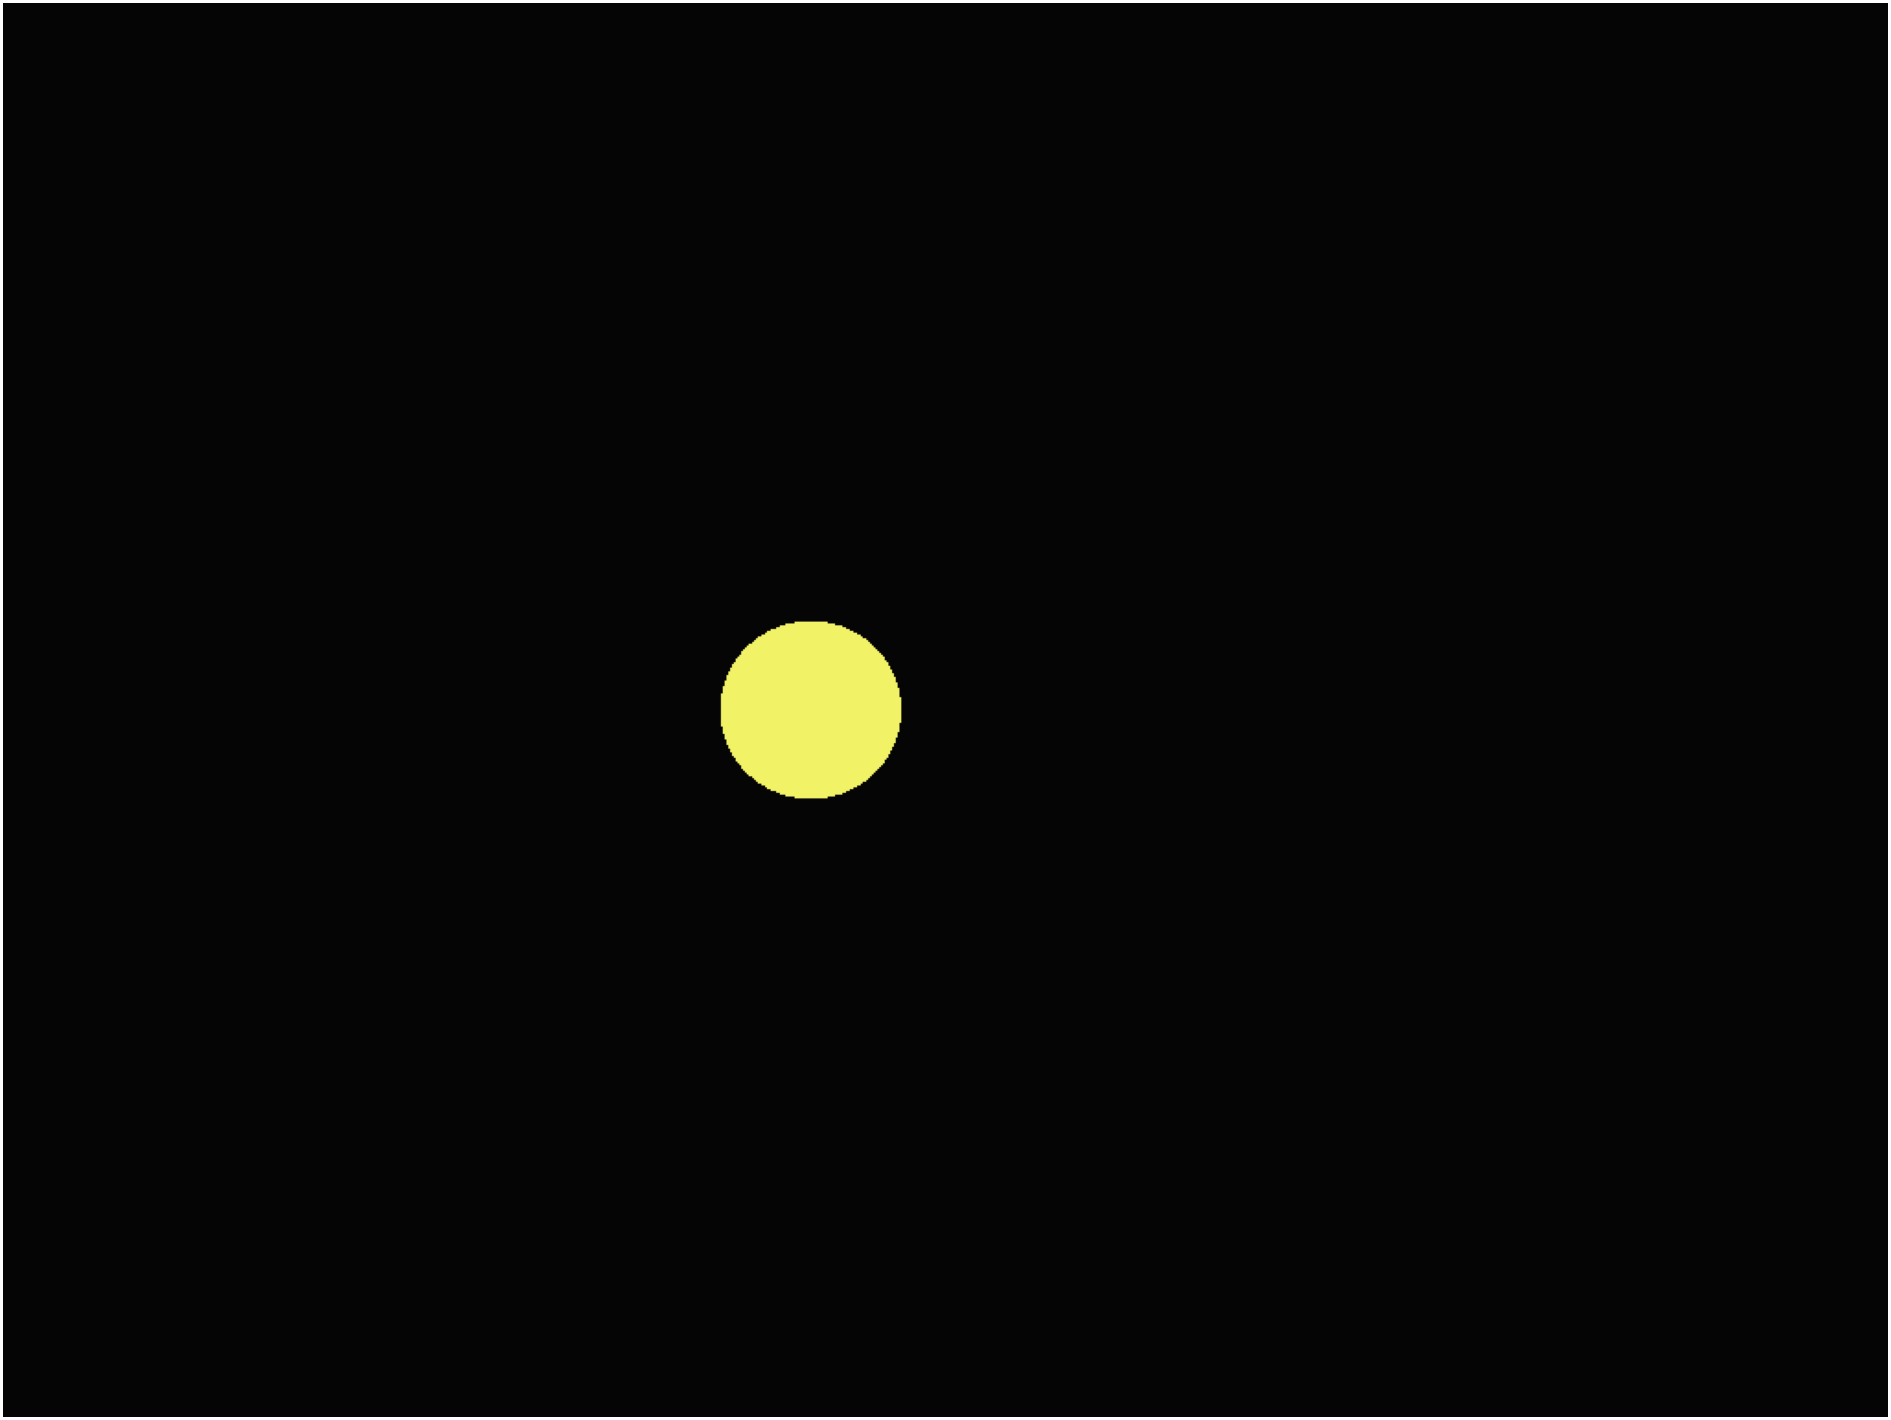

In [8]:
from math import tan, acos
from algorithm import parallelize

fn create_image_with_sphere(sphere: Sphere, height: Int, width: Int) -> Image:
    let image = Image(height, width)

    @parameter
    fn _process_row(row: Int):
        let y = -((2.0 * row + 1) / height -1)
        for col in range(width):
            let x = ((2.0 * col + 1) / width - 1) * width / height
            let dir = Vec3f(x, y, -1).normalize()
            image.set(row, col, cast_ray(Vec3f.zero(), dir, sphere))

    parallelize[_process_row](height)

    return image

render(
    create_image_with_sphere(Sphere(Vec3f(-3, 0, -16), 2, shiny_yellow), H, W)
)

In [12]:
from algorithm import parallelize
from math.limit import inf
# DynamicVector doesn't work in jupyter environment yet
from collections.vector import _OldDynamicVector as DynamicVector

fn scene_intersect(
    orig: Vec3f,
    dir: Vec3f,
    spheres: DynamicVector[Sphere],
    background: Material,
 ) -> Material:
    var spheres_dist = inf[DType.float32]()
    var material = background

    for i in range(spheres.size):
        var dist = inf[DType.float32]()
        if spheres_dist[i].intersects(orig, dir, dist) and dist < spheres_dist:
            spheres_dist = dist
            material = spheres[i].material
    
    return material

fn cast_ray(
    orig: Vec3f, dir: Vec3f, spheres: DynamicVector[Sphere]
) -> Material:
    let background = Material(Vec3f(0.02, 0.02, 0.02))
    return scene_intersect(orig, dir, spheres, background)

fn create_image_with_spheres(
    spheres: DynamicVector[Sphere], height: Int, width: Int
) -> Image:
    let image = Image(height, width)

    @parameter
    fn _process_row(row: Int):
        let y = -((2.0 * row + 1) / height - 1)
        for col in range(width):
            let x = ((2.0 * col + 1) / width - 1) * width / height
            let dir = Vec3f(x, y, -1).normalize()
            image.set(row, col, cast_ray(Vec3f.zero(), dir, spheres).color)

    parallelize[_process_row](height)

    return image

let spheres = DynamicVector[Sphere]()
spheres.push_back(Sphere(Vec3f(-3,      0, -16),   2, shiny_yellow))
spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 1.8, shiny_yellow))
spheres.push_back(Sphere(Vec3f(1.5,  -0.5, -18),   3, shiny_yellow))
spheres.push_back(Sphere(Vec3f(7,       5, -18),   4, shiny_yellow))

render(create_image_with_spheres(spheres, H, W))


error: Expression [12]:15:33: unexpected token in expression
    for i in range(spheres.size):
                                ^

error: Expression [12]:15:33: statements must start at the beginning of a line
    for i in range(spheres.size):
                                ^

expression failed to parse (no further compiler diagnostics)